This is the implementation of DCGAN with normalize input:
- Number of epochs: 100
- lr: 0.0002
- input: normalize (0.5, 0.5, 0.5)
- Add results dir for images and loss
- Add weight_decay: 1e-4

# Import

In [1]:
import argparse
import os
import time
import pickle

In [2]:
import torch
import torch.nn as nn
import torch.nn.init as init
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torchnet.meter import AverageValueMeter

# Define Arguments

In [18]:
parser = {
    'data_path': './data/ut-zap50k/Shoes/Sneakers_and_athletic_shoes/',
    'epochs': 100,
    'batch_size': 64,
    'lr': 0.0002,
    'image_size': 136,
    'scale_size': 64,
    'z_dim': 100,
    'G_features': 64,
    'D_features': 64,
    'image_channels': 3,
    'beta1': 0.5,
    'cuda': True,
    'seed': 7,
    'workers': 2,
    'results': './resultsDCGAN2_0522/'    
}
args = argparse.Namespace(**parser)
args.image_results = args.results + 'images/'
args.loss_results = args.results + 'loss/'
args.cuda = args.cuda and torch.cuda.is_available()

if not os.path.isdir(args.data_path):
    os.makedirs(args.data_path)
if not os.path.isdir(args.results):
    os.makedirs(args.results)
if not os.path.isdir(args.image_results):
    os.makedirs(args.image_results)
if not os.path.isdir(args.loss_results):
    os.makedirs(args.loss_results)
    
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

# Prepare Data

**Note: all iamges have size 136x102**

In [6]:
from folder import ImageFolder

In [7]:
from torchvision.transforms import ToPILImage
to_image = ToPILImage()

In [8]:
def get_loader(image_root, batch_size, scale_size, num_workers=2, shuffle=True):
    #image_root = os.path.join(root, 'splits', split)
    dataset = ImageFolder(root=image_root, transform=transforms.Compose([
            transforms.Pad(34, fill=(255, 255, 255)), # padding images with (255,255,255) --> pad 255 in 3 channels
            transforms.CenterCrop((136,136)),
            transforms.Scale(scale_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]))

    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, num_workers=int(num_workers))
    #data_loader.shape = [int(num) for num in dataset[0][0].size()]

    return data_loader

In [9]:
dataloader = get_loader(args.data_path, args.batch_size, args.scale_size)

Found 12856 images in subfolders of: ./data/ut-zap50k/Shoes/Sneakers_and_athletic_shoes/


## Test One Image

In [10]:
test_image = 0
for data, _ in dataloader:
    print(data[0])
    test_image = data[0]
    break


(0 ,.,.) = 
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
           ...             ⋱             ...          
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000

(1 ,.,.) = 
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
           ...             ⋱             ...          
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000

(2 ,.,.) = 
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
           ...            

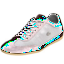

In [11]:
to_image(test_image)

# Define Model

## Define G

In [12]:
class _netG(nn.Module):
    def __init__(self):
        super(_netG, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(args.z_dim, args.G_features * 8,
                               4, 1, 0, bias=False),
            nn.BatchNorm2d(args.G_features * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(args.G_features * 8, args.G_features * 4,
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(args.G_features * 4),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(args.G_features * 4, args.G_features * 2,
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(args.G_features * 2),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(args.G_features * 2, args.G_features,
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(args.G_features),
            nn.ReLU(True),
            # state size. (ngf) x 16 x 16
            nn.ConvTranspose2d(args.G_features, args.image_channels,
                               4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 32 x 32
        )
        self._initialize_weights()
        
    # custom weight initialization
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                init.normal(m.weight, mean=0, std=0.02)
            elif isinstance(m, nn.BatchNorm2d):
                init.normal(m.weight, mean=1, std=0.02)
                init.constant(m.bias, 0)

    def forward(self, x):
        return self.main(x)

## Define D

In [13]:
class _netD(nn.Module):
    def __init__(self):
        super(_netD, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 32 x 32
            nn.Conv2d(args.image_channels, args.D_features,
                      4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(args.D_features, args.D_features * 2,
                      4, 2, 1, bias=False),
            nn.BatchNorm2d(args.D_features * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(args.D_features * 2, args.D_features * 4,
                      4, 2, 1, bias=False),
            nn.BatchNorm2d(args.D_features * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(args.D_features * 4, args.D_features * 8,
                      4, 2, 1, bias=False),
            nn.BatchNorm2d(args.D_features * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(args.D_features * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        self._initialize_weights()
        
    # custom weight initialization
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                init.normal(m.weight, mean=0, std=0.02)
            elif isinstance(m, nn.BatchNorm2d):
                init.normal(m.weight, mean=1, std=0.02)
                init.constant(m.bias, 0)

    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1)

## Save losses

In [21]:
class Results():
    def __init__(self, results_path):
        self.D_losses = []
        self.G_losses = []
        self.D_reals = []
        self.D_fakes = []
        self.G_reals = []
        self.results_path = results_path
    
    def save_losses(self, D_loss, G_loss, D_real, D_fake, G_real):
        self.D_losses.append(D_loss)
        self.G_losses.append(G_loss)
        self.D_reals.append(D_real)
        self.D_fakes.append(D_fake)
        self.G_reals.append(G_real)
        
    def save_to_disk(self):
        f = open(self.results_path + "D_losses.pkl", "wb")
        pickle.dump(self.D_losses, f)
        f= open(self.results_path + "G_losses.pkl", "wb")
        pickle.dump(self.G_losses, f)
        f = open(self.results_path + "D_reals.pkl", "wb")
        pickle.dump(self.D_reals, f)
        f = open(self.results_path + "D_fakes.pkl", "wb")
        pickle.dump(self.D_fakes, f)
        f = open(self.results_path + "G_reals.pkl", "wb")
        pickle.dump(self.G_reals, f)
        

## Define Train and Generate

In [17]:
def train(args, data_loader, netG, netD, G_optimizer, D_optimizer,
          criterion, epoch, result_losses):
    D_losses = AverageValueMeter()
    G_losses = AverageValueMeter()
    D_reals = AverageValueMeter()
    D_fakes = AverageValueMeter()
    G_reals = AverageValueMeter()
    
    start = time.time()
    # call Variable after .cuda()
    for i, (real, _) in enumerate(data_loader):
        batch_size = real.size(0)
        real_label = torch.ones(batch_size)
        fake_label = torch.zeros(batch_size)
        z = torch.randn(batch_size, args.z_dim, 1, 1)
        if args.cuda:
            real_label = real_label.cuda()
            fake_label = fake_label.cuda()
            real = real.cuda()
            z = z.cuda()
        real_label = Variable(real_label)
        fake_label = Variable(fake_label)
        real = Variable(real)
        z = Variable(z)
        
        real_output = netD(real)
        D_real_loss = criterion(real_output, real_label)
        D_real = real_output.data.mean()
        
        fake = netG(z)
        fake_output = netD(fake.detach())
        D_fake_loss = criterion(fake_output, fake_label)
        D_fake = fake_output.data.mean()
        
        D_loss = D_real_loss + D_fake_loss
        netD.zero_grad()
        D_loss.backward()
        D_optimizer.step()
        
        output = netD(fake)
        G_loss = criterion(output, real_label)
        G_real = output.data.mean()
        netG.zero_grad()
        G_loss.backward()
        G_optimizer.step()
        
        D_losses.add(D_loss.data.cpu()[0] * batch_size, batch_size)
        G_losses.add(G_loss.data.cpu()[0] * batch_size, batch_size)
        D_reals.add(D_real * batch_size, batch_size)
        D_fakes.add(D_fake * batch_size, batch_size)
        G_reals.add(G_real * batch_size, batch_size)
        
    print("=> EPOCH {} | Time: {}s | D_loss: {:.4f} | G_loss: {:.4f}"
          " | D_real: {:.4f} | D_fake: {:.4f} | G_real: {:.4f}"
          .format(epoch, round(time.time()-start), D_losses.value()[0],
                  G_losses.value()[0], D_reals.value()[0],
                  D_fakes.value()[0], G_reals.value()[0]))
    result_losses.save_losses(D_losses.value()[0],
                  G_losses.value()[0], D_reals.value()[0],
                  D_fakes.value()[0], G_reals.value()[0])

In [23]:
def generate(args, netG, epoch):
    z = torch.randn(args.batch_size, args.z_dim, 1, 1)
    if args.cuda:
        z = z.cuda()
    fake = netG(Variable(z, volatile=True))
    save_image(fake.data.cpu(), os.path.join(args.image_results,
        "fake_sample_epoch_{:02d}.png".format(epoch)), normalize=True)

## Create Model, Define Loss and Optimizer

In [24]:
netG = _netG()
netD = _netD()
criterion = nn.BCELoss()
if args.cuda:
    netD.cuda()
    netG.cuda()
    criterion.cuda()

In [25]:
D_optimizer = optim.Adam(netD.parameters(), lr=args.lr,
                         betas=(args.beta1, 0.999), weight_decay=1e-4)
G_optimizer = optim.Adam(netG.parameters(), lr=args.lr,
                         betas=(args.beta1, 0.999), weight_decay=1e-4)

## Run Train

In [27]:
result_losses = Results(args.loss_results)
for epoch in range(0, args.epochs):
    train(args, dataloader, netG, netD, G_optimizer, D_optimizer,
          criterion, epoch, result_losses)
    generate(args, netG, epoch)

=> EPOCH 0 | Time: 143s | D_loss: 0.6464 | G_loss: 8.2103 | D_real: 0.8575 | D_fake: 0.1617 | G_real: 0.0295
=> EPOCH 1 | Time: 46s | D_loss: 0.6803 | G_loss: 4.1346 | D_real: 0.7952 | D_fake: 0.2038 | G_real: 0.0745
=> EPOCH 2 | Time: 47s | D_loss: 0.6986 | G_loss: 3.9589 | D_real: 0.7904 | D_fake: 0.2102 | G_real: 0.0831
=> EPOCH 3 | Time: 46s | D_loss: 0.7565 | G_loss: 3.2702 | D_real: 0.7576 | D_fake: 0.2436 | G_real: 0.1105
=> EPOCH 4 | Time: 47s | D_loss: 0.8624 | G_loss: 3.0206 | D_real: 0.7249 | D_fake: 0.2723 | G_real: 0.1281
=> EPOCH 5 | Time: 47s | D_loss: 0.9268 | G_loss: 2.8281 | D_real: 0.7079 | D_fake: 0.2910 | G_real: 0.1421
=> EPOCH 6 | Time: 47s | D_loss: 0.8775 | G_loss: 2.6961 | D_real: 0.7076 | D_fake: 0.2905 | G_real: 0.1407
=> EPOCH 7 | Time: 47s | D_loss: 0.8848 | G_loss: 2.6454 | D_real: 0.7071 | D_fake: 0.2923 | G_real: 0.1506
=> EPOCH 8 | Time: 47s | D_loss: 0.8425 | G_loss: 2.6060 | D_real: 0.7157 | D_fake: 0.2804 | G_real: 0.1516
=> EPOCH 9 | Time: 47s | D_

=> EPOCH 76 | Time: 47s | D_loss: 0.0448 | G_loss: 5.3036 | D_real: 0.9786 | D_fake: 0.0211 | G_real: 0.0128
=> EPOCH 77 | Time: 47s | D_loss: 0.1853 | G_loss: 5.1695 | D_real: 0.9424 | D_fake: 0.0573 | G_real: 0.0366
=> EPOCH 78 | Time: 47s | D_loss: 0.1350 | G_loss: 5.5044 | D_real: 0.9640 | D_fake: 0.0371 | G_real: 0.0284
=> EPOCH 79 | Time: 47s | D_loss: 0.5788 | G_loss: 4.0936 | D_real: 0.8261 | D_fake: 0.1722 | G_real: 0.1123
=> EPOCH 80 | Time: 47s | D_loss: 0.1095 | G_loss: 5.1886 | D_real: 0.9611 | D_fake: 0.0370 | G_real: 0.0247
=> EPOCH 81 | Time: 47s | D_loss: 0.5522 | G_loss: 3.9973 | D_real: 0.8276 | D_fake: 0.1744 | G_real: 0.1115
=> EPOCH 82 | Time: 47s | D_loss: 0.0829 | G_loss: 5.1403 | D_real: 0.9634 | D_fake: 0.0365 | G_real: 0.0194
=> EPOCH 83 | Time: 47s | D_loss: 0.0904 | G_loss: 5.2883 | D_real: 0.9649 | D_fake: 0.0349 | G_real: 0.0228
=> EPOCH 84 | Time: 47s | D_loss: 0.0427 | G_loss: 5.5336 | D_real: 0.9800 | D_fake: 0.0200 | G_real: 0.0124
=> EPOCH 85 | Time:

=> EPOCH 151 | Time: 47s | D_loss: 0.0311 | G_loss: 6.6727 | D_real: 0.9863 | D_fake: 0.0139 | G_real: 0.0066
=> EPOCH 152 | Time: 47s | D_loss: 0.0354 | G_loss: 6.8370 | D_real: 0.9857 | D_fake: 0.0144 | G_real: 0.0088
=> EPOCH 153 | Time: 47s | D_loss: 0.0219 | G_loss: 7.0106 | D_real: 0.9901 | D_fake: 0.0099 | G_real: 0.0052
=> EPOCH 154 | Time: 47s | D_loss: 0.3401 | G_loss: 5.9977 | D_real: 0.9229 | D_fake: 0.0766 | G_real: 0.0512
=> EPOCH 155 | Time: 47s | D_loss: 0.1342 | G_loss: 6.0821 | D_real: 0.9569 | D_fake: 0.0435 | G_real: 0.0203
=> EPOCH 156 | Time: 47s | D_loss: 0.0496 | G_loss: 6.6391 | D_real: 0.9801 | D_fake: 0.0201 | G_real: 0.0102
=> EPOCH 157 | Time: 47s | D_loss: 0.0979 | G_loss: 6.7287 | D_real: 0.9716 | D_fake: 0.0274 | G_real: 0.0160
=> EPOCH 158 | Time: 47s | D_loss: 0.0310 | G_loss: 6.8879 | D_real: 0.9863 | D_fake: 0.0136 | G_real: 0.0062
=> EPOCH 159 | Time: 47s | D_loss: 0.1377 | G_loss: 6.5436 | D_real: 0.9652 | D_fake: 0.0348 | G_real: 0.0232
=> EPOCH 1

=> EPOCH 226 | Time: 47s | D_loss: 0.0209 | G_loss: 7.4704 | D_real: 0.9909 | D_fake: 0.0092 | G_real: 0.0041
=> EPOCH 227 | Time: 47s | D_loss: 0.1008 | G_loss: 7.9255 | D_real: 0.9755 | D_fake: 0.0237 | G_real: 0.0122
=> EPOCH 228 | Time: 47s | D_loss: 0.0314 | G_loss: 7.8120 | D_real: 0.9873 | D_fake: 0.0128 | G_real: 0.0049
=> EPOCH 229 | Time: 47s | D_loss: 0.0627 | G_loss: 7.6634 | D_real: 0.9799 | D_fake: 0.0201 | G_real: 0.0089
=> EPOCH 230 | Time: 47s | D_loss: 0.0594 | G_loss: 7.5240 | D_real: 0.9797 | D_fake: 0.0202 | G_real: 0.0087
=> EPOCH 231 | Time: 47s | D_loss: 0.0235 | G_loss: 7.8987 | D_real: 0.9905 | D_fake: 0.0096 | G_real: 0.0042
=> EPOCH 232 | Time: 47s | D_loss: 0.1438 | G_loss: 7.9043 | D_real: 0.9667 | D_fake: 0.0313 | G_real: 0.0177
=> EPOCH 233 | Time: 47s | D_loss: 0.0696 | G_loss: 7.4251 | D_real: 0.9766 | D_fake: 0.0249 | G_real: 0.0085
=> EPOCH 234 | Time: 47s | D_loss: 0.1335 | G_loss: 7.4057 | D_real: 0.9659 | D_fake: 0.0341 | G_real: 0.0180
=> EPOCH 2

=> EPOCH 301 | Time: 47s | D_loss: 0.2296 | G_loss: 7.1026 | D_real: 0.9641 | D_fake: 0.0348 | G_real: 0.0247
=> EPOCH 302 | Time: 47s | D_loss: 0.0911 | G_loss: 7.5784 | D_real: 0.9718 | D_fake: 0.0286 | G_real: 0.0122
=> EPOCH 303 | Time: 47s | D_loss: 0.0269 | G_loss: 7.8701 | D_real: 0.9891 | D_fake: 0.0107 | G_real: 0.0045
=> EPOCH 304 | Time: 47s | D_loss: 0.0166 | G_loss: 7.8513 | D_real: 0.9927 | D_fake: 0.0074 | G_real: 0.0030
=> EPOCH 305 | Time: 47s | D_loss: 0.1760 | G_loss: 7.5702 | D_real: 0.9657 | D_fake: 0.0332 | G_real: 0.0211
=> EPOCH 306 | Time: 47s | D_loss: 0.0894 | G_loss: 7.3681 | D_real: 0.9741 | D_fake: 0.0261 | G_real: 0.0119
=> EPOCH 307 | Time: 47s | D_loss: 0.0675 | G_loss: 7.3781 | D_real: 0.9789 | D_fake: 0.0212 | G_real: 0.0121
=> EPOCH 308 | Time: 47s | D_loss: 0.0237 | G_loss: 7.7670 | D_real: 0.9900 | D_fake: 0.0101 | G_real: 0.0043
=> EPOCH 309 | Time: 47s | D_loss: 0.0200 | G_loss: 7.5970 | D_real: 0.9912 | D_fake: 0.0084 | G_real: 0.0052
=> EPOCH 3

=> EPOCH 376 | Time: 47s | D_loss: 0.1770 | G_loss: 8.2963 | D_real: 0.9639 | D_fake: 0.0354 | G_real: 0.0213
=> EPOCH 377 | Time: 47s | D_loss: 0.0285 | G_loss: 7.7555 | D_real: 0.9894 | D_fake: 0.0112 | G_real: 0.0048
=> EPOCH 378 | Time: 47s | D_loss: 0.0284 | G_loss: 7.6884 | D_real: 0.9888 | D_fake: 0.0113 | G_real: 0.0057
=> EPOCH 379 | Time: 47s | D_loss: 0.0263 | G_loss: 8.0384 | D_real: 0.9895 | D_fake: 0.0097 | G_real: 0.0077
=> EPOCH 380 | Time: 47s | D_loss: 0.0723 | G_loss: 8.5396 | D_real: 0.9808 | D_fake: 0.0200 | G_real: 0.0094
=> EPOCH 381 | Time: 47s | D_loss: 0.0346 | G_loss: 8.1809 | D_real: 0.9875 | D_fake: 0.0126 | G_real: 0.0055
=> EPOCH 382 | Time: 47s | D_loss: 0.0368 | G_loss: 8.3253 | D_real: 0.9873 | D_fake: 0.0125 | G_real: 0.0049
=> EPOCH 383 | Time: 47s | D_loss: 0.0202 | G_loss: 8.1668 | D_real: 0.9928 | D_fake: 0.0074 | G_real: 0.0031
=> EPOCH 384 | Time: 47s | D_loss: 0.1085 | G_loss: 8.4604 | D_real: 0.9760 | D_fake: 0.0240 | G_real: 0.0139
=> EPOCH 3

=> EPOCH 451 | Time: 47s | D_loss: 0.0178 | G_loss: 7.8155 | D_real: 0.9923 | D_fake: 0.0078 | G_real: 0.0032
=> EPOCH 452 | Time: 47s | D_loss: 0.0256 | G_loss: 8.0922 | D_real: 0.9907 | D_fake: 0.0091 | G_real: 0.0047
=> EPOCH 453 | Time: 47s | D_loss: 0.0748 | G_loss: 8.3978 | D_real: 0.9834 | D_fake: 0.0166 | G_real: 0.0097
=> EPOCH 454 | Time: 47s | D_loss: 0.1060 | G_loss: 7.6965 | D_real: 0.9778 | D_fake: 0.0222 | G_real: 0.0115
=> EPOCH 455 | Time: 47s | D_loss: 0.0266 | G_loss: 7.6089 | D_real: 0.9891 | D_fake: 0.0108 | G_real: 0.0039
=> EPOCH 456 | Time: 47s | D_loss: 0.0213 | G_loss: 7.9721 | D_real: 0.9915 | D_fake: 0.0085 | G_real: 0.0030
=> EPOCH 457 | Time: 47s | D_loss: 0.1775 | G_loss: 7.6466 | D_real: 0.9678 | D_fake: 0.0310 | G_real: 0.0176
=> EPOCH 458 | Time: 47s | D_loss: 0.0243 | G_loss: 7.3001 | D_real: 0.9899 | D_fake: 0.0104 | G_real: 0.0048
=> EPOCH 459 | Time: 47s | D_loss: 0.0185 | G_loss: 7.5895 | D_real: 0.9918 | D_fake: 0.0084 | G_real: 0.0044
=> EPOCH 4

## Save loss

In [28]:
result_losses.save_to_disk()

## Get one REAL Image

In [72]:
sample, _ = iter(dataloader).next()
save_image(sample, os.path.join(args.results, "real_sample.png"))